# **MODEL**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255)
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/ML-Project/train',
                                                 batch_size = 20,
                                                     target_size = (150,150),
                                                 class_mode = 'binary')

Found 1044 images belonging to 2 classes.


In [ ]:
validate_datagen = ImageDataGenerator(rescale = 1./255)
validate_set = validate_datagen.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/ML-Project/validate',
                                                 batch_size = 20,
                                                 target_size = (150,150),
                                                 class_mode = 'binary')

Found 136 images belonging to 2 classes.


In [ ]:
validate_set.class_indices

{'bricks': 0, 'rebars': 1}

In [ ]:
validate_inputs, validate_targets = next(iter(validate_set))

In [ ]:
HP_FILTER_SIZE = hp.HParam('filter_size',hp.Discrete([3,5,7]))
HP_FILTER_NUM = hp.HParam('filter_num',hp.Discrete([32,64,96]))

METRIC_ACCURACY = hp.Metric('accuracy',display_name='Accuracy')

with tf.summary.create_file_writer('/content/drive/MyDrive/Colab Notebooks/ML-Project/data_logs').as_default():
    hp.hparams_config(hparams=[HP_FILTER_SIZE,HP_FILTER_NUM],
                     metrics=[METRIC_ACCURACY])

In [ ]:
def train_test_model(hparams):
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(hparams[HP_FILTER_NUM],hparams[HP_FILTER_SIZE],activation='relu',input_shape=[150,150,3]))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
    model.add(tf.keras.layers.Conv2D(hparams[HP_FILTER_NUM],3,activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
    model.add(tf.keras.layers.Conv2D(hparams[HP_FILTER_NUM],3,activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
    #model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units = 512 , activation='relu'))
    model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
    
    optimizer_fn = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer_fn,loss='binary_crossentropy',metrics=['accuracy'])

    
    Early_Stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                 mode='auto',
                                                 min_delta=0,
                                                 patience=3,
                                                 verbose=0,
                                                 restore_best_weights=True)
    
    model.fit(training_set,validation_data = (validate_inputs,validate_targets), 
              callbacks = [Early_Stopping], verbose = 2, epochs = 15)
    
    _,accuracy = model.evaluate(validate_inputs,validate_targets)
    
    return accuracy

In [ ]:
def run(log_dir,hparams):
    with tf.summary.create_file_writer(log_dir).as_default():
        hp.hparams(hparams)
        accuracy = train_test_model(hparams)
        tf.summary.scalar('accuracy',accuracy,step=1)

In [ ]:
session_num = 1

for filter_size in HP_FILTER_SIZE.domain.values:
    for filter_num in HP_FILTER_NUM.domain.values:
        
        hparams = {HP_FILTER_SIZE:filter_size,
                  HP_FILTER_NUM:filter_num}
        run_name = "run-%d" %session_num
        print('-- Starting-trail: %s' %run_name)
        print({h.name:hparams[h] for h in hparams})
        run('/content/drive/MyDrive/Colab Notebooks/ML-Project/data_logs/' + run_name, hparams)
        
        session_num = session_num + 1

-- Starting-trail: run-1
{'filter_size': 3, 'filter_num': 32}
Epoch 1/15
53/53 - 133s - loss: 0.4980 - accuracy: 0.7318 - val_loss: 0.6369 - val_accuracy: 0.5500 - 133s/epoch - 3s/step
Epoch 2/15
53/53 - 65s - loss: 0.3295 - accuracy: 0.8400 - val_loss: 0.1941 - val_accuracy: 0.9500 - 65s/epoch - 1s/step
Epoch 3/15
53/53 - 68s - loss: 0.2484 - accuracy: 0.8985 - val_loss: 0.3529 - val_accuracy: 0.8500 - 68s/epoch - 1s/step
Epoch 4/15
53/53 - 74s - loss: 0.2400 - accuracy: 0.8946 - val_loss: 0.3503 - val_accuracy: 0.9000 - 74s/epoch - 1s/step
Epoch 5/15
53/53 - 78s - loss: 0.1630 - accuracy: 0.9310 - val_loss: 0.1322 - val_accuracy: 0.9500 - 78s/epoch - 1s/step
Epoch 6/15
53/53 - 73s - loss: 0.1367 - accuracy: 0.9435 - val_loss: 0.9342 - val_accuracy: 0.8000 - 73s/epoch - 1s/step
Epoch 7/15
53/53 - 72s - loss: 0.2179 - accuracy: 0.9128 - val_loss: 0.2669 - val_accuracy: 0.9000 - 72s/epoch - 1s/step
Epoch 8/15
53/53 - 68s - loss: 0.0706 - accuracy: 0.9751 - val_loss: 0.1559 - val_accurac

In [ ]:
%load_ext tensorboard
%tensorboard --logdir "/content/drive/MyDrive/Colab Notebooks/ML-Project/hparam_tuning/"

In [ ]:
# taskkill /im tensorboard.exe /f
# del /q %TMP%\.tensorboard-info\*

In [ ]:
model_cnn = tf.keras.Sequential()
model_cnn.add(tf.keras.layers.Conv2D(32,5,activation='relu',input_shape=[150,150,3]))
model_cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model_cnn.add(tf.keras.layers.Conv2D(32,5,activation='relu'))
model_cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model_cnn.add(tf.keras.layers.Conv2D(32,3,activation='relu'))
model_cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
#model_cnn.add(tf.keras.layers.Dropout(0.1))
model_cnn.add(tf.keras.layers.Flatten())
model_cnn.add(tf.keras.layers.Dense(units = 512 , activation='relu'))
model_cnn.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

optimizer_fn = tf.keras.optimizers.Adam(learning_rate=0.001)
model_cnn.compile(optimizer=optimizer_fn,loss='binary_crossentropy',metrics=['accuracy'])
    
Early_Stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                 mode='auto',
                                                 min_delta=0,
                                                 patience=3,
                                                 verbose=0,
                                                 restore_best_weights=True)
    
model_cnn.fit(training_set,validation_data = (validate_inputs,validate_targets), 
              callbacks = [Early_Stopping], verbose = 2, epochs = 20)
    
_,accuracy = model_cnn.evaluate(validate_inputs,validate_targets)
    
print(f'Accuracy based on Validation data is {accuracy*100:.2f}')

Epoch 1/20
53/53 - 90s - loss: 0.7305 - accuracy: 0.6140 - val_loss: 0.6996 - val_accuracy: 0.4500 - 90s/epoch - 2s/step
Epoch 2/20
53/53 - 85s - loss: 0.5117 - accuracy: 0.7155 - val_loss: 0.5132 - val_accuracy: 0.4500 - 85s/epoch - 2s/step
Epoch 3/20
53/53 - 86s - loss: 0.4380 - accuracy: 0.7605 - val_loss: 0.3620 - val_accuracy: 0.8500 - 86s/epoch - 2s/step
Epoch 4/20
53/53 - 87s - loss: 0.4106 - accuracy: 0.7864 - val_loss: 0.9278 - val_accuracy: 0.4500 - 87s/epoch - 2s/step
Epoch 5/20
53/53 - 87s - loss: 0.3668 - accuracy: 0.8238 - val_loss: 0.4513 - val_accuracy: 0.8000 - 87s/epoch - 2s/step
Epoch 6/20
53/53 - 86s - loss: 0.3444 - accuracy: 0.8448 - val_loss: 0.2323 - val_accuracy: 0.9500 - 86s/epoch - 2s/step
Epoch 7/20
53/53 - 85s - loss: 0.3054 - accuracy: 0.8707 - val_loss: 0.1861 - val_accuracy: 0.9500 - 85s/epoch - 2s/step
Epoch 8/20
53/53 - 102s - loss: 0.2031 - accuracy: 0.9128 - val_loss: 0.1852 - val_accuracy: 1.0000 - 102s/epoch - 2s/step
Epoch 9/20
53/53 - 95s - loss:

In [ ]:
from tensorflow.keras.models import load_model
model_cnn.save('/content/drive/MyDrive/Colab Notebooks/ML-Project/saved_model/model_cnn.h5')    #.h5 or .hdf5

In [ ]:
from tensorflow.keras.models import load_model
model_cnn.save('/content/drive/MyDrive/Colab Notebooks/ML-Project/saved_model/model_cnn.hdf5')      #.h5 or .hdf5

Found 140 images belonging to 2 classes.
1/1 [==============================] - 0s 422ms/step - loss: 0.1357 - accuracy: 0.9500
Accuracy based on Test data is 95.00%
1/1 [==============================] - 1s 511ms/step
[[15  0]
 [ 5  0]]


Text(33.0, 0.5, 'Predicted class')

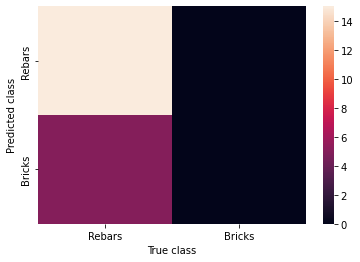

In [ ]:
Test_datagen = ImageDataGenerator(rescale = 1./255)
Test_set = Test_datagen.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/ML-Project/test',
                                                 batch_size = 20,
                                                 target_size = (150,150),
                                                 class_mode = 'binary')

test_inputs, test_targets = next(iter(Test_set))

_,accuracy = model_cnn.evaluate(test_inputs,test_targets)
print(f'Accuracy based on Test data is {accuracy*100:.2f}%')

test_pred_raw = model_cnn.predict(test_inputs)
test_pred = np.argmax(test_pred_raw, axis=1)
cm = confusion_matrix(test_targets, test_pred)

print(cm)

sns.heatmap(cm,xticklabels=['Rebars','Bricks'],yticklabels=['Rebars','Bricks'])
plt.xlabel('True class')
plt.ylabel('Predicted class')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
new_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/ML-Project/saved_model/model_cnn.h5')
new_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 146, 146, 32)      2432      
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 73, 73, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 69, 69, 32)        25632     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 34, 34, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 16, 16, 32)     

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/ML-Project/saved_model/model_cnn.hdf5')

# Show the model architecture
new_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 146, 146, 32)      2432      
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 73, 73, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 69, 69, 32)        25632     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 34, 34, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 16, 16, 32)     

#TESTING

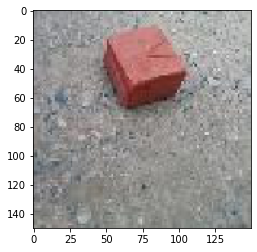

1/1 [==============================] - 0s 175ms/step
Bricks are detected


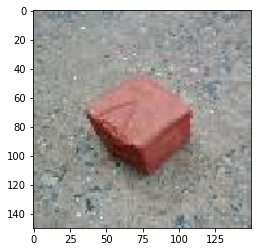

1/1 [==============================] - 0s 80ms/step
Bricks are detected


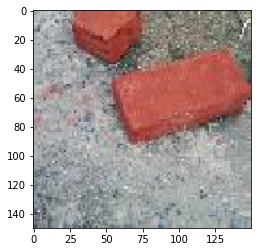

1/1 [==============================] - 0s 80ms/step
Bricks are detected


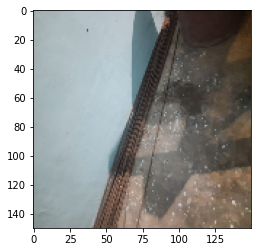

1/1 [==============================] - 0s 71ms/step
Rebars are detected


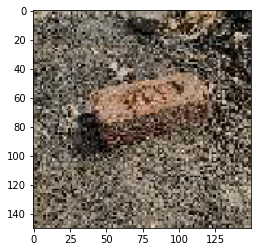

1/1 [==============================] - 0s 59ms/step
Bricks are detected


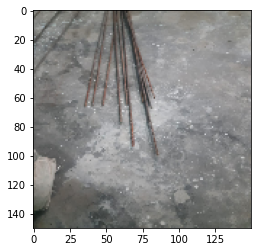

1/1 [==============================] - 0s 56ms/step
Rebars are detected


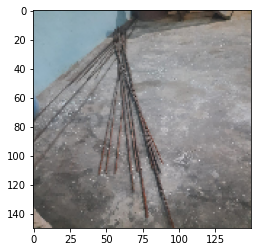

1/1 [==============================] - 0s 61ms/step
Rebars are detected


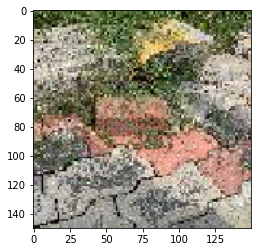

1/1 [==============================] - 0s 51ms/step
Bricks are detected


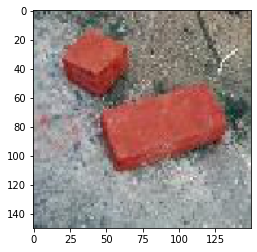

1/1 [==============================] - 0s 51ms/step
Bricks are detected


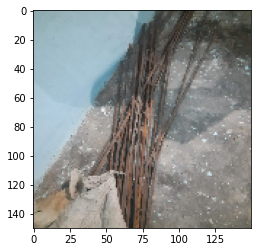

1/1 [==============================] - 0s 69ms/step
Rebars are detected


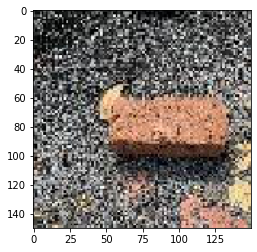

1/1 [==============================] - 0s 74ms/step
Bricks are detected


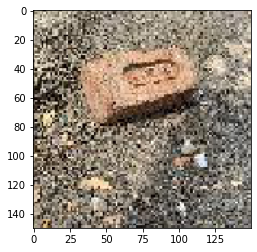

1/1 [==============================] - 0s 63ms/step
Bricks are detected


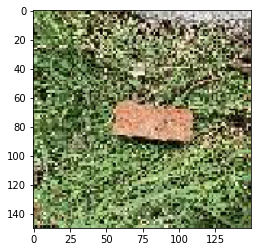

1/1 [==============================] - 0s 64ms/step
Bricks are detected


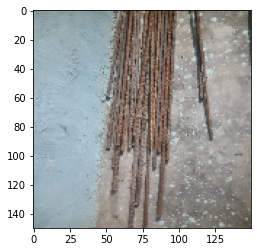

1/1 [==============================] - 0s 78ms/step
Rebars are detected


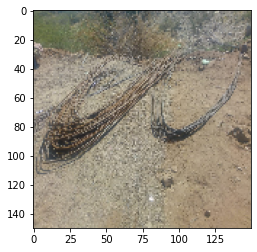

1/1 [==============================] - 0s 75ms/step
Rebars are detected


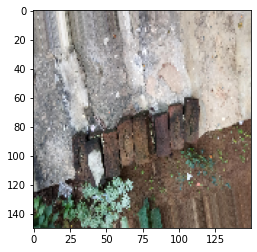

1/1 [==============================] - 0s 56ms/step
Rebars are detected


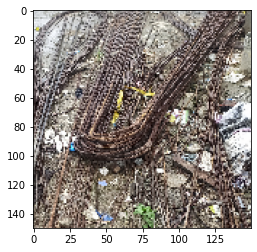

1/1 [==============================] - 0s 70ms/step
Rebars are detected


In [ ]:
import os
from keras.preprocessing import image
from keras.utils import image_utils as U

test_path = '/content/drive/MyDrive/Colab Notebooks/ML-CE6051/testing_test'

for i in os.listdir(test_path):
    img = U.load_img(test_path+ '//'+ i,target_size=(150,150))
    plt.imshow(img)
    plt.show()
    X=U.img_to_array(img)
    X= np.expand_dims(X,axis=0)
    images=np.vstack([X])

    val=new_model.predict(images)
    if val== 0:
        print("Bricks are detected")
    else:
        print("Rebars are detected")

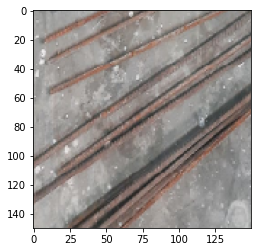

1/1 [==============================] - 0s 34ms/step
[[0.5133966]]
Rebars


In [ ]:
from keras.utils import image_utils as image
import numpy as np
import matplotlib.pyplot as plt

image_1 = '/content/200122.png'
test_image = image.load_img(image_1,target_size = (150,150))
plt.imshow(test_image)
plt.show()
test_image = image.img_to_array(test_image)
test_image = test_image/255
test_image = np.expand_dims(test_image, axis = 0)

result = new_model.predict(test_image)
print(result)
if result[0][0] < 0.5:
    prediction = 'Bricks'
else:
    prediction = 'Rebars'
print(prediction)

In [ ]:
image_2 = '/content/rebar_1.jpg'
test_image = image.load_img(image_2,target_size = (150,150))
plt.imshow(test_image)
plt.show()
test_image = image.img_to_array(test_image)
test_image = test_image/255
image.array_to_img(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = new_model.predict(test_image)
print(result)
if result[0][0] < 0.5:
    prediction = 'Bricks'
else:
    prediction = 'Rebars'
print(prediction)

FileNotFoundError: ignored

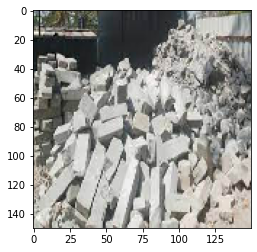

1/1 [==============================] - 0s 36ms/step
[[0.82553744]]
Rebars


In [ ]:
image_3 = '/content/2.jpg'
test_image = image.load_img(image_3,target_size = (150,150))
plt.imshow(test_image)
plt.show()
test_image = image.img_to_array(test_image)
test_image = test_image/255
image.array_to_img(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = new_model.predict(test_image)
print(result)
if result[0][0] < 0.5:
    prediction = 'Bricks'
else:
    prediction = 'Rebars'
print(prediction)